# 5. Visualizing movement models in epymorph

epymorph expresses a model's movement dynamics as Movement Models: modular components which support rapid experimentation and comparison. To help visualize the differences between movements models, we can plot their concepts of movement probability between geographic nodes.

We'll use the counties geo we created (and cached) in part 3.

In [1]:
import numpy as np

from epymorph import *
from epymorph.geo.cache import load_from_cache
from epymorph.geo.geo import Geo


def load_example_geo() -> Geo:
    geo = load_from_cache('demo-four-states-by-county')
    if geo is None:
        msg = "Can't load the demo-four-states-by-county geo from cache; see demo part 3 for that."
        raise Exception(msg)
    return geo


geo = load_example_geo()

# We can extract the state fips codes from the county fips codes.
state_fips = {s[:2] for s in geo['geoid']}

# Find Maricopa County's index in the geo
MARICOPA_CO_IDX = np.where(geo['geoid'] == '04013')[0][0]

## Centroids movement

Although a movement model normally encapsulates this detail, we'll "extract" its movement kernel here so we can map one row of it.

In [2]:
import numpy as np

from epymorph.util import pairwise_haversine, row_normalize

params = {
    'phi': 40.0,
}


def calc_centroids_kernel():
    centroid = geo['centroid']
    distance = pairwise_haversine(centroid['longitude'], centroid['latitude'])
    return row_normalize(1 / np.exp(distance / params['phi']))


centroids_kernel = np.log(calc_centroids_kernel())

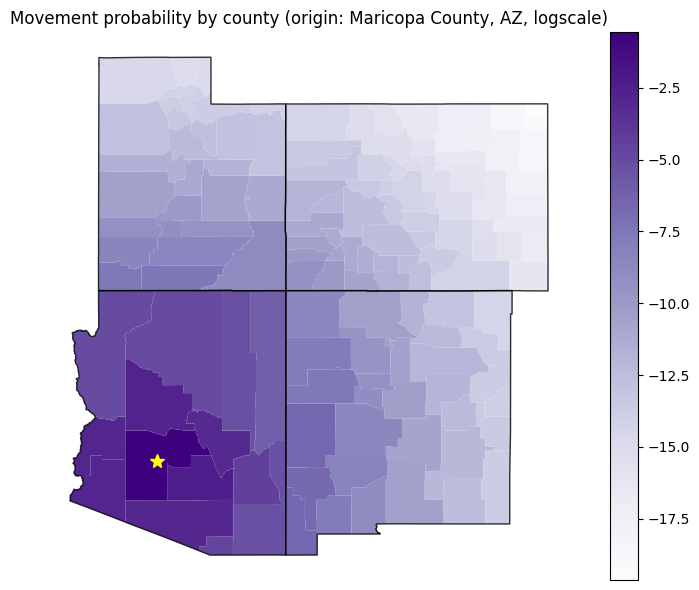

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import pygris

df_states = pygris.states(cb=True, resolution='5m', cache=True, year=2020)
df_states = df_states.loc[df_states['GEOID'].isin(state_fips)]

df_counties = pd.concat([
    pygris.counties(state=s, cb=True, resolution='5m', cache=True, year=2020)
    for s in state_fips
])

df_merged = pd.merge(
    on="GEOID",
    left=df_counties,
    right=pd.DataFrame({
        'GEOID': geo['geoid'],
        'data': centroids_kernel[MARICOPA_CO_IDX],
    }),
)

fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('off')
ax.set_title("Movement probability by county (origin: Maricopa County, AZ, logscale)")
df_merged.plot(ax=ax, column='data', cmap='Purples', legend=True)
df_states.plot(ax=ax, linewidth=1, edgecolor='black', color='none', alpha=0.8)
# Get Maricopa County's centroid from the geo so we can mark it.
origin = geo['centroid'][MARICOPA_CO_IDX]
ax.plot(origin[0], origin[1], marker='*', color='yellow', markersize=10)
fig.tight_layout()
plt.show()

## Commuters movement

We can do a similar treatment with the commuters movement model, where movement probability is based not on distance, but ACS Commuter Flows data at the county granularity.

In [4]:
import numpy as np

from epymorph.util import row_normalize

# Commuters as a ratio to the total commuters living in that county.
pei_kernel = np.log(row_normalize(geo['commuters']) + 0.0000000001)

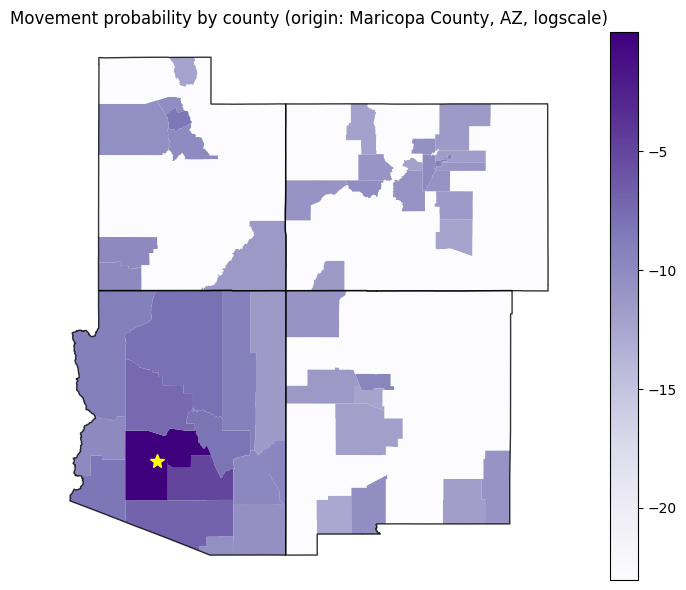

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import pygris

df_states = pygris.states(cb=True, resolution='5m', cache=True, year=2020)
df_states = df_states.loc[df_states['GEOID'].isin(state_fips)]

df_counties = pd.concat([
    pygris.counties(state=s, cb=True, resolution='5m', cache=True, year=2020)
    for s in state_fips
])

df_merged = pd.merge(
    on="GEOID",
    left=df_counties,
    right=pd.DataFrame({
        'GEOID': geo['geoid'],
        'data': pei_kernel[MARICOPA_CO_IDX],
    }),
)


fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('off')
ax.set_title("Movement probability by county (origin: Maricopa County, AZ, logscale)")
df_merged.plot(ax=ax, column='data', cmap='Purples', legend=True)
df_states.plot(ax=ax, linewidth=1, edgecolor='black', color='none', alpha=0.8)
# Get Maricopa County's centroid from the geo so we can mark it.
origin = geo['centroid'][MARICOPA_CO_IDX]
ax.plot(origin[0], origin[1], marker='*', color='yellow', markersize=10)
fig.tight_layout()
plt.show()